In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# 1 Generative adversarial network


In [ ]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataroot = "/content/drive/MyDrive/dcgan3"
dataroot_mini = "/content/drive/MyDrive/dcgan"

In [ ]:
# !unzip -qq  /content/drive/MyDrive/img_align_celeba.zip -d /content/drive/MyDrive/dcgan3

# (a)
我將圖片Resize成64*64的大小，並進行Cropping，由之前CNN的作業可得知，做過Cropping後的圖片訓練效果較好。

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataset_mini = dset.ImageFolder(root=dataroot_mini,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 202599
    Root location: /content/drive/MyDrive/dcgan3
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True, num_workers=2)
dataloader_mini = torch.utils.data.DataLoader(dataset_mini,batch_size=128,shuffle=True, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class generator(nn.Module):
  def __init__(self,d,layer=[4,2,1],n=8):
    super(generator,self).__init__()
    self.size = n
    layers = []
    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(100,d*8,4,1,0),
        nn.BatchNorm2d(d*8),
        nn.ReLU(True)
    )
    for i in layer:
      layers.append(nn.Sequential(
          nn.ConvTranspose2d(d*self.size,d*i,4,2,1),
          nn.BatchNorm2d(d*i),
          nn.ReLU(True)
      ))
      self.size = i
    self.middle_layer = nn.Sequential(*layers)
    self.final_layer = nn.Sequential(
        nn.ConvTranspose2d(d,3,4,2,1),
        nn.Tanh()
    )
    

  def weight_init(self,mean,std):
    for j in self.modules():
      if isinstance(j,nn.ConvTranspose2d):
        j.weight.data.normal_(mean, std)
        j.bias.data.zero_()
        
  def forward(self,x):
    h = self.layer1(x)
    h = self.middle_layer(h)
    h = self.final_layer(h)
    return h


In [ ]:
class discriminator(nn.Module):
  def __init__(self,nd=64,layer=[2,4,8],n=1):
    super(discriminator,self).__init__()
    layers = []
    self.size = n
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,nd,4,2,1),
        nn.LeakyReLU(0.2,inplace=True)
            )
    for i in layer:
      layers.append(nn.Sequential(
          nn.Conv2d(nd*self.size,nd*i,4,2,1,bias=False),
          nn.BatchNorm2d(nd*i),
          nn.LeakyReLU(0.2,inplace=True)
      ))
      self.size = i
    self.middle_layer = nn.Sequential(*layers)
    self.final_layer = nn.Sequential(
        nn.Conv2d(nd*8,1,4,1,0,bias=False),
        nn.Sigmoid()
    )

  def weight_init(self,mean,std):
    for j in self.modules():
      if isinstance(j,nn.Conv2d):
        j.weight.data.normal_(mean, std)
        # j.bias.data.zero_()

  def forward(self,x):
    h = self.layer1(x)
    h = self.middle_layer(h)
    h = self.final_layer(h)
    return h


In [ ]:
def train(loader,g,d,opt_g,opt_d,criterion,epoch):
  g_loss = []
  d_loss = []
  img_5 = []
  img_last = []
  noise = torch.randn(64, 100, 1, 1, device=device)
  iters = 0
  for e in range(epoch):
    print(e)
    for i,data in enumerate(loader,0):
      d.zero_grad()
      real = data[0].to(device)
      label = torch.full((real.size(0),),1.,dtype=torch.float, device=device)
      out_d = d(real).view(-1)
      errd_real = criterion(out_d,label)
      errd_real.backward()
      fake = g(torch.randn(real.size(0),100,1,1,device=device))
      out_d_fake = d(fake.detach()).view(-1)
      label.fill_(0.)
      errd_fake = criterion(out_d_fake,label)
      errd_fake.backward()
      errd = errd_real + errd_fake
      opt_d.step()

      g.zero_grad()
      out_g = d(fake).view(-1)
      label.fill_(1.)
      errg = criterion(out_g,label)
      errg.backward()
      opt_g.step()
      g_loss.append(errg.item())
      d_loss.append(errd.item())
      if iters == 5:
        with torch.no_grad():
          fake_5 = g(noise).detach().cpu()
          img_5.append(vutils.make_grid(fake_5, padding=2, normalize=True))
      if ((e==epoch-1) and (i==len(loader)-1)):
        with torch.no_grad():
          fake_last = g(noise).detach().cpu()
          img_last.append(vutils.make_grid(fake_last, padding=2, normalize=True)) 
      iters += 1
  return g_loss,d_loss,img_5,img_last




In [ ]:
def plot_loss(G_loss,D_loss):
  plt.title("Loss")
  plt.plot(G_loss,label="Loss G")
  plt.plot(D_loss,label="Loss D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
g = generator(d=64)
g.weight_init(0,0.02)
g.to(device)

generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (middle_layer): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (final_layer): Sequential(
 

In [ ]:
d = discriminator()
d.weight_init(0,0.02)
d.to(device)

discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (middle_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  

In [ ]:
cri = nn.BCELoss()
optimizerD = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
g_loss,d_loss,img_5,img_last = train(dataloader,g,d,optimizerG,optimizerD,cri,5)

0
1
2
3
4


# (b)
 Plot the learning curves for both generator and discriminator

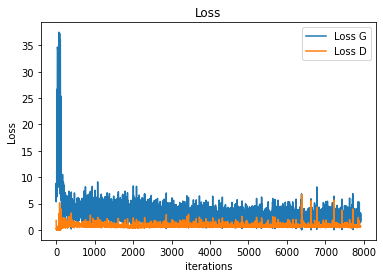

In [ ]:
plot_loss(g_loss,d_loss)

# (c)
由於一開始畫出迭代5次的圖完全無法辨識，我在下面用了比較少量的資料集再訓練出一張圖進行比對，一樣能解釋出迭代次數較少的話，生成模型的效果較差。

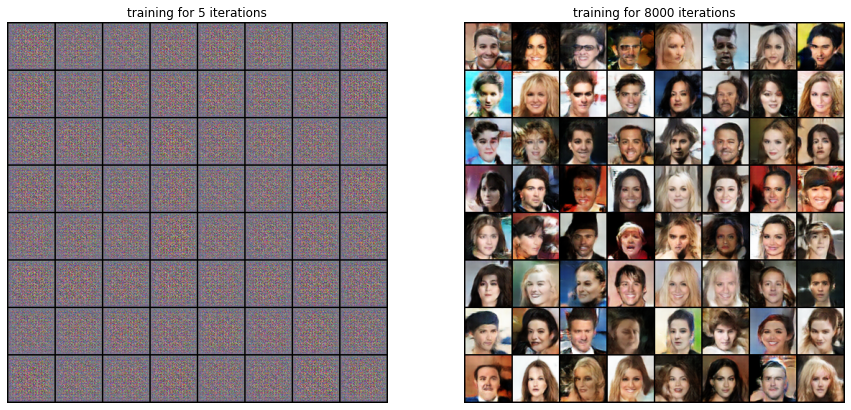

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("training for 5 iterations")
plt.imshow(np.transpose(img_5[-1],(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("training for 8000 iterations")
plt.imshow(np.transpose(img_last[-1],(1,2,0)))
plt.show()

In [ ]:
g_mini = generator(d=64).to(device)
g_mini.weight_init(0,0.02)
d_mini = discriminator().to(device)
d_mini.weight_init(0,0.02)
cri_mini = nn.BCELoss()
optimizerD_mini = optim.Adam(d_mini.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG_mini = optim.Adam(g_mini.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_loss_mini,d_loss_mini,img_5_mini,img_last_mini = train(dataloader_mini,g_mini,d_mini,optimizerG_mini,optimizerD_mini,cri_mini,5)

0
1
2
3
4


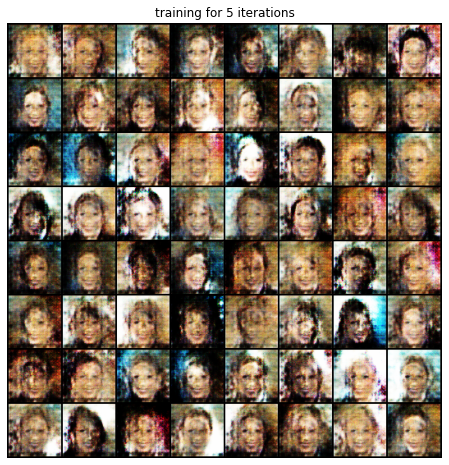

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("training for 5 iterations")
plt.imshow(np.transpose(img_last_mini[-1],(1,2,0)))

## 2.
Please answer the following questions in your submission report, you can refer to the
paper to answer these questions.

##### (a)



黑色虛線是指真實樣本的分布狀況，z則為noise，z指向x的線表示noise經過generator到真實資料分布狀況的mapping。由(A)圖可看出藍色虛線有許多ripple，代表discriminator仍不穩定。因此此階段是訓練discriminator，由圖(B)可看出經訓練後虛線已平穩許多。(B)到(C)階段則是訓練generator，可看出雜訊經訓練過的generator映射後能更加擬合真實資料的分布。而訓練的目標函數則為:

max
L(D) = E[log D(x)] + E[
log(1 − D(G(z)))]

min
L(G) = E[
log(1 − D(G(z))]

而當discriminator等於0.5時代表我們產生的圖片足以以假亂真，讓discriminator無法分辨真假，只能每張圖片都猜真或假，此時訓練完成。


##### (b)

簡單來說， The Helvetica Scenario是當generator發現生成某些資料能一直騙過discriminator時，不管輸入何種雜訊皆生成相同的數據，進而導致模型的崩潰。避免的方法有使用其他的Loss function，例如Wasserstein loss.

##### (c)

根據之前作業可知，兩者在訓練的方式有所不同。VAE是最大化ELBO，最小化訓練模型機率分布與資料機率分布之間KL Divergence。GAN則是最小化模型與資料間的Jensen-Shannon Divergence。VAE能通過編碼解碼的過程去比較原始圖片和重建圖片的差異，這是GAN沒有的。相對地，由於沒有對抗網路，VAE生成的圖片也較為模糊。而GAN也有Model collapse及可能不收斂等缺點。